In [273]:
import pandas as pd
from utils import *

import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pytrends.request import TrendReq
import requests

In [ ]:
@everyone die Tabelle data/new.csv enthält die Daten bisher (ich muss noch die neuen Faktoren hinzufügen, aber ein paar sind schon drin). 
Könntet ihr ein paar Plots zur Verteilung der Daten machen?
Die Spalten GINI_HND,I_IUSNET,F10_RT sind die Faktoren. Alle anderen Spalten sind die verschiedenen Verbrechen, jeweils in absolut und normiert. Ich würde die normierten nehemen, die Spalten haben jeweils die Endung _P_HTHAB, also z.B. ICCS05021_P_HTHAB.
Intentional homicide könnte interessant sein, das wäre crime code ICCS0101

ICCS0101    Mord 
ICCS0102:   versuchter Mord

ICCS020111: Schwere Körperverletzung 

ICCS020221: Entführung

ICCS0301:   Sexuelle Gewalt 
ICCS03011:  Vergewaltigung 
ICCS03012:  Sexuelle Übergriffe
ICCS0302:   Sexuelle Ausbeutung 

ICCS0401:   Raub 

ICCS0501:   Einbruch
ICCS05012:  Einbruch in private Wohnräume 

ICCS0502:   Diebstahl
ICCS05021:  Diebstahl eines motorisierten Fahrzeugs oder Teilen davon

ICCS0601:   Rechtswidrige Handlungen im Zusammenhang mit kontrollierten Drogen oder Vorläuferstoffen

ICCS0701:   Betrug 
ICCS0703:   Korruption 
ICCS07031:  Bestechung

ICCS07041:  Geldwäsche 
ICCS09051:  Beteiligung an einer organisierten kriminellen Vereinigung

ICCS0903:   Handlungen gegen Computersysteme


dfcrime = pd.read_csv("Crimes_per_100tsd_estat_crim_off_cat_en.csv")
dfalc = pd.read_csv("../raw_data/Death_to_alcoholic_abuse_tps00140_linear.csv")
dfgini = pd.read_csv("../raw_data/Gini_index_tessi190_linear.csv")
 = pd.read_csv("../raw_data/Healthy_life_years_by_sex_hlth_hlye_linear.csv")
 = pd.read_csv("../raw_data/Healthy_life_years_hlth_hlye_linear.csv")
 = pd.read_csv("../raw_data/Participation_in_social_networks_testat_tin00127_en.csv")
 = pd.read_csv("../raw_data/People_risk_poverty_or_social_exclusion_sdg_01_10_linear.csv")
 = pd.read_csv("../raw_data/Unemployment_rate_tipsun20_linear.csv")

GoogleDF = pd.read_csv("geoMap.csv", skiprows=3, \
                       names=["Country", "G2013", "G2015"]) 

GoogleDF.dropna(axis = 0, how = 'any', inplace = True)

GoogleDF['G2013'] = GoogleDF['G2013'].str.replace('\%','',regex=True).astype(int)

GoogleDF['G2015'] = GoogleDF['G2015'].str.replace('\%','',regex=True).astype(int)

GoogleDF.head()

In [59]:
dfgini = pd.read_csv("../raw_data/Gini_index_tessi190_linear.csv")
dfgini[['geo', 'geo_d']] = dfgini['geo'].str.split(':', expand=True)
dfgini.dropna(subset=['OBS_VALUE'], inplace=True)
dfgini

,DATAFLOW,LAST UPDATE,freq,indic_il,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,geo_d
6,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),AL,2017,36.8,NaN,Albania
7,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),AL,2018,35.4,NaN,Albania
8,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),AL,2019,34.3,NaN,Albania
9,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),AL,2020,33.2,NaN,Albania
10,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),AL,2021,33.0,NaN,Albania
...,...,...,...,...,...,...,...,...,...
483,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),UK,2014,31.6,NaN,United Kingdom
484,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),UK,2015,32.4,NaN,United Kingdom
485,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),UK,2016,31.5,NaN,United Kingdom
486,ESTAT:TESSI190(1.0),22/12/23 11:00:00,A:Annual,GINI_HND:Gini coefficient (scale from 0 to 100),UK,2017,33.1,b,United Kingdom


In [217]:
def normalize(df, column_name='geo'):
    delimiter = ":"
    new_column_names = [column_name, column_name + '_d']
    df[new_column_names] = df[column_name].str.split(delimiter, expand=True)
    
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    return df

def grouping(df, rename='value', agg='mean'):
    #df.dropna(subset=['OBS_VALUE'], inplace=True)
    df = df.groupby(['geo', 'TIME_PERIOD']).agg({'OBS_VALUE': agg})#, 'geo_d': 'max'})
    df.rename(columns={'TIME_PERIOD': 'year'}, inplace=True)
    df.rename(columns={'OBS_VALUE': rename}, inplace=True)
    return df

In [281]:
tablelist = [\
           #('dfcrime','dfcrime',"Crimes_per_100tsd_estat_crim_off_cat_en.csv"),
           ('dfalc','d_alc',"../raw_data/Death_to_alcoholic_abuse_tps00140_linear.csv",'sum'), \
           ('dfgini','gini',"../raw_data/Gini_index_tessi190_linear.csv",'mean'), \
           #('dfhage','h_age',"../raw_data/Healthy_life_years_by_sex_hlth_hlye_linear.csv"), \
           ('dfhealthage','h_age',"../raw_data/Healthy_life_years_hlth_hlye_linear.csv",'mean'), \
           ('dfsocnet','socnet',"../raw_data/Participation_in_social_networks_testat_tin00127_en.csv",'mean'), \
           ('dfpoverty','poverty',"../raw_data/People_risk_poverty_or_social_exclusion_sdg_01_10_linear.csv",'sum'), \
           ('dfunemp','unemp',"../raw_data/Unemployment_rate_tipsun20_linear.csv",'mean')]
#Nachschauen worauf sich d_alc der Wert bezieht!!!!
## Wie wird poverty das gemessen?????
for dataframe, name, value, agg in tablelist:
    exec(f"{dataframe} = pd.read_csv('{value}')")
    #exec(f"print('{dataframe}', len({dataframe}) )")   
    #exec(f"print({dataframe})")

dfalc  = dfalc.loc[dfalc ['sex'] == 'T:Total']
dfhealthage = dfhealthage.loc[dfhealthage ['sex'] == 'T:Total']
dfhealthage = dfhealthage[dfhealthage['indic_he'].str.startswith('HLY_PC_0')]
dfpoverty   = dfpoverty[dfpoverty['age'].str.startswith('TOTAL:Total')]
dfpoverty   = dfpoverty[dfpoverty['unit'].str.startswith('PC:Percentage')]                      
dfunemp     = dfunemp[dfunemp['unit'].str.startswith('PC_ACT')]     
dfunemp     = dfunemp[dfunemp['age'].str.startswith('Y25-74')]

#for dataframe, name, value, agg in tablelist:
#    exec(f"print('{dataframe}', len({dataframe}) )")   

dfall = dfalc
dfall = dfall.reset_index()
dfall.drop(columns=dfall.columns.difference(['geo', 'TIME_PERIOD']), axis=1, inplace=True)
#print(dfall)

for dataframe, name, value, agg in tablelist:
    exec(f"{dataframe} = grouping({dataframe}, '{name}', '{agg}')")
    exec(f"dfall = pd.merge(dfall, {dataframe}, on=['geo', 'TIME_PERIOD'], how='outer')")

dfcrime = pd.read_csv("../raw_data/Crimes_per_100tsd_estat_crim_off_cat_en.csv")
dfcrime.rename(columns={'OBS_VALUE': 'Nr_Crimes'}, inplace=True)
dfcrime = dfcrime[dfcrime['unit'].str.startswith('P_HTHAB')]
#dfcrime = dfcrime[dfcrime['iccs'].str.startswith('ICCS0101')\
                  #|dfcrime['iccs'].str.startswith('ICCS03')\
#                 ]
#dfcrime = dfcrime.groupby(['geo', 'TIME_PERIOD'])['Nr_Crimes'].sum()
dfcrime = dfcrime.groupby(['geo', 'TIME_PERIOD', 'iccs'])['Nr_Crimes'].sum()
dfcrime = dfcrime.reset_index()
dfcrime = normalize(dfcrime)
dfcrime.drop('geo_d', axis=1, inplace=True)
dfcrime = normalize(dfcrime,'iccs')

dfall = normalize(dfall)
dfall = pd.merge(dfall, dfcrime, on=['geo', 'TIME_PERIOD'], how='inner')
dfall.to_csv('../data/df_all.csv', index=False)

print(dfall)

#print(dfcrime['iccs'].unique())

     geo  TIME_PERIOD  d_alc  gini  h_age  socnet  poverty  unemp    geo_d  \
0     AL         2011    0.0   NaN    NaN     NaN      NaN    NaN  Albania   
1     AL         2011    0.0   NaN    NaN     NaN      NaN    NaN  Albania   
2     AL         2011    0.0   NaN    NaN     NaN      NaN    NaN  Albania   
3     AL         2011    0.0   NaN    NaN     NaN      NaN    NaN  Albania   
4     AL         2011    0.0   NaN    NaN     NaN      NaN    NaN  Albania   
...   ..          ...    ...   ...    ...     ...      ...    ...      ...   
7008  IT         2010    NaN   NaN    NaN     NaN      NaN    7.1    Italy   
7009  IT         2010    NaN   NaN    NaN     NaN      NaN    7.1    Italy   
7010  IT         2010    NaN   NaN    NaN     NaN      NaN    7.1    Italy   
7011  IT         2010    NaN   NaN    NaN     NaN      NaN    7.1    Italy   
7012  IT         2010    NaN   NaN    NaN     NaN      NaN    7.1    Italy   

            iccs  Nr_Crimes                                    

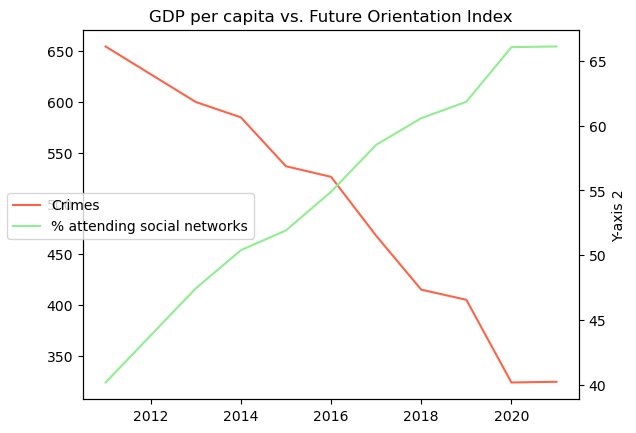

NameError: name 'LinearRegression' is not defined

In [274]:
dfout = dfall
dfout.dropna(subset=['socnet'], inplace=True)
dfout.dropna(subset=['Nr_Crimes'], inplace=True)
#dfout.dropna(subset=['gini'], inplace=True)
dfout = dfout[dfout['iccs'].str.startswith('ICCS05')\
                  #|dfout['iccs'].str.startswith('ICCS03')\
                 ]
#dfout = dfout.groupby(['geo', 'TIME_PERIOD'])[['Nr_Crimes'],['gini']].sum()
dfout = dfout.groupby([#'geo', 
                       'TIME_PERIOD']).agg({  'Nr_Crimes': 'mean'#})
                                            , 'gini'     : 'mean'
                                            , 'socnet'   : 'mean'
                                            })
dfout = dfout.reset_index()
#df_austria = dfcrime_alc[dfcrime_alc['geo'] == 'AT']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfout['TIME_PERIOD'], dfout['Nr_Crimes'], color='tomato', label='Crimes')
ax2.plot(dfout['TIME_PERIOD'], dfout['socnet'], color='lightgreen', label='% attending social networks')
#ax2.scatter(dfout['TIME_PERIOD'], dfout['gini'], color='darkgoldenrod', label='Gini-Index')

#ax1.set_title('Scatter Plot with Two Lines')
#ax1.set_xlabel('X-axis')
#ax1.set_ylabel('Y-axis 1')
ax2.set_ylabel('Y-axis 2')

plt.title('GDP per capita vs. Future Orientation Index')
#plt.ylabel('GDP per capita')
fig.legend(loc=6)
plt.show()


model = LinearRegression().fit(dfout[["Nr_Crimes"]],dfout["socnet"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)

#ICCS0903
#die Tabelle data/new.csv enthält die Daten bisher (ich muss noch die neuen Faktoren hinzufügen, aber ein paar sind schon drin). 
#Könntet ihr ein paar Plots zur Verteilung der Daten machen?
#Die Spalten GINI_HND,I_IUSNET,F10_RT sind die Faktoren. Alle anderen Spalten sind die verschiedenen Verbrechen, jeweils in absolut und normiert. Ich würde die normierten nehemen, die Spalten haben jeweils die Endung _P_HTHAB, also z.B. ICCS05021_P_HTHAB.
#Intentional homicide könnte interessant sein, das wäre crime code ICCS0101. 


     geo  TIME_PERIOD  d_alc  gini  h_age  socnet  poverty  unemp     geo_d  \
95    AL         2018   0.00  35.4    NaN   48.33     53.9    NaN   Albania   
114   AL         2019   0.00  34.3    NaN   52.13     50.7    NaN   Albania   
133   AL         2020   0.00  33.2    NaN   54.80     46.2    NaN   Albania   
218   AT         2016   5.70  27.2   69.7   49.02     17.2    5.7   Austria   
238   AT         2017   5.63  27.9   69.9   51.19     17.1    5.3   Austria   
...   ..          ...    ...   ...    ...     ...      ...    ...       ...   
5723  RO         2021    NaN  34.3   79.4   68.55     34.4    4.5   Romania   
5756  SE         2021    NaN  26.8   82.3   71.51     17.2    6.8    Sweden   
5772  SI         2021    NaN  23.0   81.0   63.61     13.2    4.2  Slovenia   
5789  SK         2021    NaN  21.8   76.1   64.58     15.6    6.1  Slovakia   
6928  XK         2017    NaN   NaN    NaN   56.50      NaN    NaN   Kosovo*   

          iccs  Nr_Crimes                         i

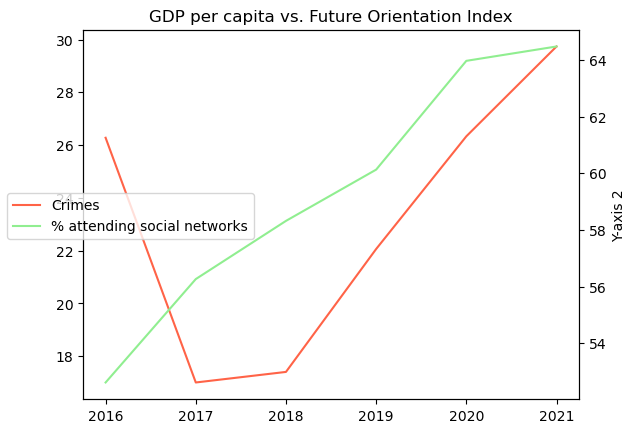

NameError: name 'LinearRegression' is not defined

In [277]:
dfout = dfall
dfout.dropna(subset=['socnet'], inplace=True)
dfout.dropna(subset=['Nr_Crimes'], inplace=True)
#dfout.dropna(subset=['gini'], inplace=True)

dfout = dfout[dfout['iccs'].str.startswith('ICCS0903')\
                  #|dfout['iccs'].str.startswith('ICCS03')\
                 ]
#dfout = dfout.groupby(['geo', 'TIME_PERIOD'])[['Nr_Crimes'],['gini']].sum()

print(dfout)

dfout = dfout.groupby([#'geo', 
                       'TIME_PERIOD']).agg({  'Nr_Crimes': 'mean'#})
                                            , 'gini'     : 'mean'
                                            , 'socnet'   : 'mean'
                                            })
dfout = dfout.reset_index()
#df_austria = dfcrime_alc[dfcrime_alc['geo'] == 'AT']

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dfout['TIME_PERIOD'], dfout['Nr_Crimes'], color='tomato', label='Crimes')
ax2.plot(dfout['TIME_PERIOD'], dfout['socnet'], color='lightgreen', label='% attending social networks')
#ax2.scatter(dfout['TIME_PERIOD'], dfout['gini'], color='darkgoldenrod', label='Gini-Index')

#ax1.set_title('Scatter Plot with Two Lines')
#ax1.set_xlabel('X-axis')
#ax1.set_ylabel('Y-axis 1')
ax2.set_ylabel('Y-axis 2')

plt.title('GDP per capita vs. Future Orientation Index')
#plt.ylabel('GDP per capita')
fig.legend(loc=6)
plt.show()


model = LinearRegression().fit(dfout[["Nr_Crimes"]],dfout["socnet"]) # Enter the data for the linear regression model
print(model.coef_, model.intercept_)

#

In [ ]:
plt.scatter(dfcrime_alc['OBS_VALUE_x'],wholeDf['OBS_VALUE_y']) # Enter the needed data to plot the scatter plot
import pandas as pd
import matplotlib.pyplot as plt

# create a sample DataFrame
df = pd.DataFrame({'x': [1, 2, 3, 4, 5], 'y1': [2, 4, 6, 8, 10], 'y2': [1, 3, 5, 7, 9]})

# plot the scatter plot with two lines

ax1.scatter(df['x'], df['y1'], color='red', label='Line 1')
ax2.scatter(df['x'], df['y2'], color='blue', label='Line 2')

# set the title and labels
ax1.set_title('Scatter Plot with Two Lines')
ax1.set_xlabel('X-axis')
ax1.set_ylabel('Y-axis 1')
ax2.set_ylabel('Y-axis 2')

# create a second x-axis for years
ax3 = ax1.twiny()
ax3.set_xticks([1, 2, 3, 4, 5])
ax3.set_xticklabels(['2017', '2018', '2019', '2020', '2021'])
ax3.set_xlabel('Year')

# show the plot
plt.show()


plt.title('GDP per capita vs. Future Orientation Index')
plt.xlabel('Future Orientation Index')
plt.ylabel('GDP per capita')
plt.show()

if not os.path.exists("plots"):
    os.makedirs("plots")

crimeDF = pd.read_csv("data/crime.csv")
for column in ["iccs", "freq", "unit", "geo"]:
    crimeDF = split_column(crimeDF, column)

# load income Gini
giniDF = pd.read_csv("data/income_gini.csv")
for column in ["indic_il", "freq", "geo"]:
    giniDF = split_column(giniDF, column)
socNetPartDF = pd.read_csv("data/social_network_participation.csv")
for column in ["indic_is", "ind_type", "freq", "unit", "geo"]:
    socNetPartDF = split_column(socNetPartDF, column)

crime2019DF = data_from_year(crimeDF, 2019)
gini2019DF = data_from_year(giniDF, 2019)
socNetPart2019DF = data_from_year(socNetPartDF, 2019)

allDF = pd.DataFrame()

# create columns for each crime
crimes = {}
for crime, crime_rows in crime2019DF.groupby(by="iccs_code"):
    tmp = pd.pivot(data=crime_rows, index="geo_code", columns="unit_code", values="OBS_VALUE")
    # tmp.rename(columns={"NR": ""})
    allDF = pd.concat([allDF, tmp.add_prefix(f"{crime}_")], axis=1)
    crimes.update({crime: crime_rows["iccs_name"].unique()[0]})

# append columns of the factors
tmp = pd.pivot(data=gini2019DF, index="geo_code", columns="indic_il_code", values="OBS_VALUE")
allDF = pd.merge(allDF, tmp, left_index=True, right_index=True)
tmp = pd.pivot(data=socNetPart2019DF, index="geo_code", columns="indic_is_name", values="OBS_VALUE")
tmp["internet_use"] = tmp["Internet use"]
allDF = pd.merge(allDF, tmp, left_index=True, right_index=True)
print(".")


# Linear regression
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
# train = X_train.join(y_train)
# test = X_test.join(y_test)
log = open("data/regression.log", 'w');
for crime_code, crime_name in crimes.items():
    try:
        model = smf.mixedlm(f"{crime_code}_P_HTHAB ~ internet_use + GINI_HND", data=allDF, groups=allDF.index)
        result = model.fit()
        # log.write(result.summary())
        # log.write(result.params)

        sns.regplot(x="GINI_HND", y=f"{crime_code}_P_HTHAB", data=allDF)
        plt.suptitle(crime_name)
        plt.savefig(f"plots/{crime_name}.png")
        plt.show()
    except IndexError:
        print(f"no fit for {crime_code}: \t'{crime_name}'")
        log.write(f"no fit for {crime_code}:\t'{crime_name}'\n")
log.close()